# Embedding Analysis & Retrieval Evaluation

This notebook analyzes embedding quality and retrieval performance for the Alzheimer's RAG system.

**Objectives:**
1. Compare different embedding models
2. Visualize embedding spaces
3. Measure retrieval quality metrics
4. Identify failure cases

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import umap
from app.services.advanced_retriever import HybridRetriever, RetrievalConfig

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Load Retriever and Data

In [2]:
# Initialize retriever
config = RetrievalConfig()
retriever = HybridRetriever(config)

print(f"Loaded {len(retriever.nodes)} document chunks")
print(f"Embedding dimension: {retriever.dense_embeddings.shape[1]}")

🚀 Initializing Advanced Hybrid Retriever...
📦 Loading dense model: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext


No sentence-transformers model found with name microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext. Creating a new one with mean pooling.


🎯 Loading cross-encoder: cross-encoder/ms-marco-MiniLM-L-6-v2
✅ Loaded 10090 nodes from JSON
📦 Loading embeddings from: C:\Bureau\projet_Dl\Projet-DL-Big-Data-\backend\data\processed\embeddings.npy
   Shape: (10090, 768)
✅ Loaded 10090 nodes from JSON
📦 Loading embeddings from: C:\Bureau\projet_Dl\Projet-DL-Big-Data-\backend\data\processed\embeddings.npy
   Shape: (10090, 768)
✅ Loaded embeddings from separate file
📚 Building indices for 10090 documents...
🔍 Checking embeddings for 10090 nodes...
✅ Loaded embeddings from separate file
📚 Building indices for 10090 documents...
🔍 Checking embeddings for 10090 nodes...
   ✅ Using pre-computed embeddings
   Embeddings matrix shape: (10090, 768)
   ✅ Using pre-computed embeddings
   Embeddings matrix shape: (10090, 768)
✅ Hybrid retriever ready!
Loaded 10090 document chunks
Embedding dimension: 768
✅ Hybrid retriever ready!
Loaded 10090 document chunks
Embedding dimension: 768


## 2. Test Queries for Evaluation

In [3]:
# Define test queries covering different topics
test_queries = [
    "What are the early symptoms of Alzheimer's disease?",
    "How is MMSE score interpreted?",
    "What treatments are available for Alzheimer's?",
    "What are the risk factors for developing dementia?",
    "How can caregivers support Alzheimer's patients?",
    
    "What is the role of amyloid beta in Alzheimer's?",
    "How does MoCA differ from MMSE?",
    "What lifestyle changes can reduce Alzheimer's risk?",
    "What are the stages of Alzheimer's disease?",
    "How do biomarkers help in Alzheimer's diagnosis?"
]

print(f"Testing with {len(test_queries)} queries")

Testing with 10 queries


## 3. Retrieval Performance Analysis

In [4]:
# Test retrieval for each query
results = []

for query in test_queries:
    docs, metrics = retriever.retrieve(query, top_k=5)
    
    results.append({
        'query': query,
        'num_results': len(docs),
        'avg_score': metrics.get('avg_score', 0),
        'max_score': metrics.get('max_score', 0),
        'min_score': metrics.get('min_score', 0)
    })

# Create DataFrame
results_df = pd.DataFrame(results)
results_df

,query,num_results,avg_score,max_score,min_score
0,What are the early symptoms of Alzheimer's dis...,5,1.439346,2.217454,0.898711
1,How is MMSE score interpreted?,2,0.176647,0.244591,0.108703
2,What treatments are available for Alzheimer's?,5,1.516352,2.334311,0.782565
3,What are the risk factors for developing demen...,5,2.030248,2.774154,1.158706
4,How can caregivers support Alzheimer's patients?,5,0.843250,1.538894,0.482307
5,What is the role of amyloid beta in Alzheimer's?,5,1.300327,2.337669,0.547841
6,How does MoCA differ from MMSE?,0,0.000000,0.000000,0.000000
7,What lifestyle changes can reduce Alzheimer's ...,1,0.055269,0.055269,0.055269
8,What are the stages of Alzheimer's disease?,5,1.823051,2.764366,0.999866
9,How do biomarkers help in Alzheimer's diagnosis?,5,1.910721,2.250960,1.544234


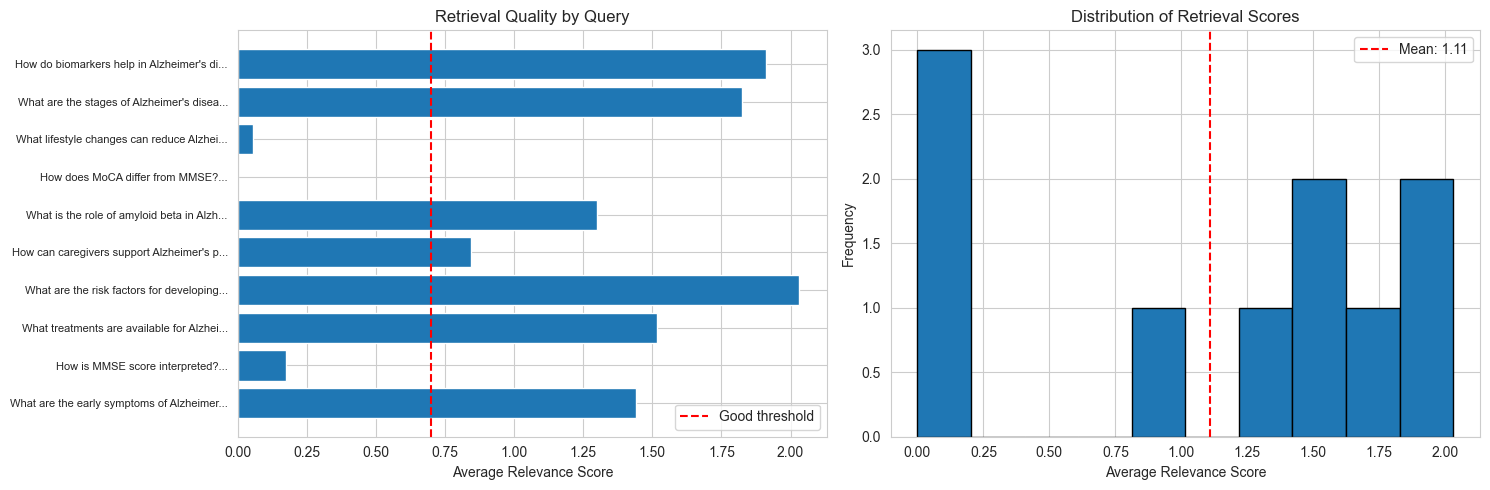


Retrieval Statistics:
Mean avg score: 1.110
Median avg score: 1.370
Queries with avg score > 0.7: 7/10


In [5]:
# Visualize retrieval scores
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Average scores
axes[0].barh(range(len(results_df)), results_df['avg_score'])
axes[0].set_yticks(range(len(results_df)))
axes[0].set_yticklabels([q[:40] + '...' for q in results_df['query']], fontsize=8)
axes[0].set_xlabel('Average Relevance Score')
axes[0].set_title('Retrieval Quality by Query')
axes[0].axvline(x=0.7, color='r', linestyle='--', label='Good threshold')
axes[0].legend()

# Score distribution
axes[1].hist(results_df['avg_score'], bins=10, edgecolor='black')
axes[1].set_xlabel('Average Relevance Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Retrieval Scores')
axes[1].axvline(x=results_df['avg_score'].mean(), color='r', linestyle='--', label=f'Mean: {results_df["avg_score"].mean():.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nRetrieval Statistics:")
print(f"Mean avg score: {results_df['avg_score'].mean():.3f}")
print(f"Median avg score: {results_df['avg_score'].median():.3f}")
print(f"Queries with avg score > 0.7: {(results_df['avg_score'] > 0.7).sum()}/{len(results_df)}")

## 4. Embedding Space Visualization

In [6]:
# Sample embeddings for visualization (use subset for speed)
sample_size = min(500, len(retriever.dense_embeddings))
sample_indices = np.random.choice(len(retriever.dense_embeddings), sample_size, replace=False)
sample_embeddings = retriever.dense_embeddings[sample_indices]

# Get document types for coloring
sample_types = [retriever.metadata[i].get('content_type', 'text') for i in sample_indices]

print(f"Visualizing {sample_size} document embeddings")

Visualizing 500 document embeddings


Running t-SNE...


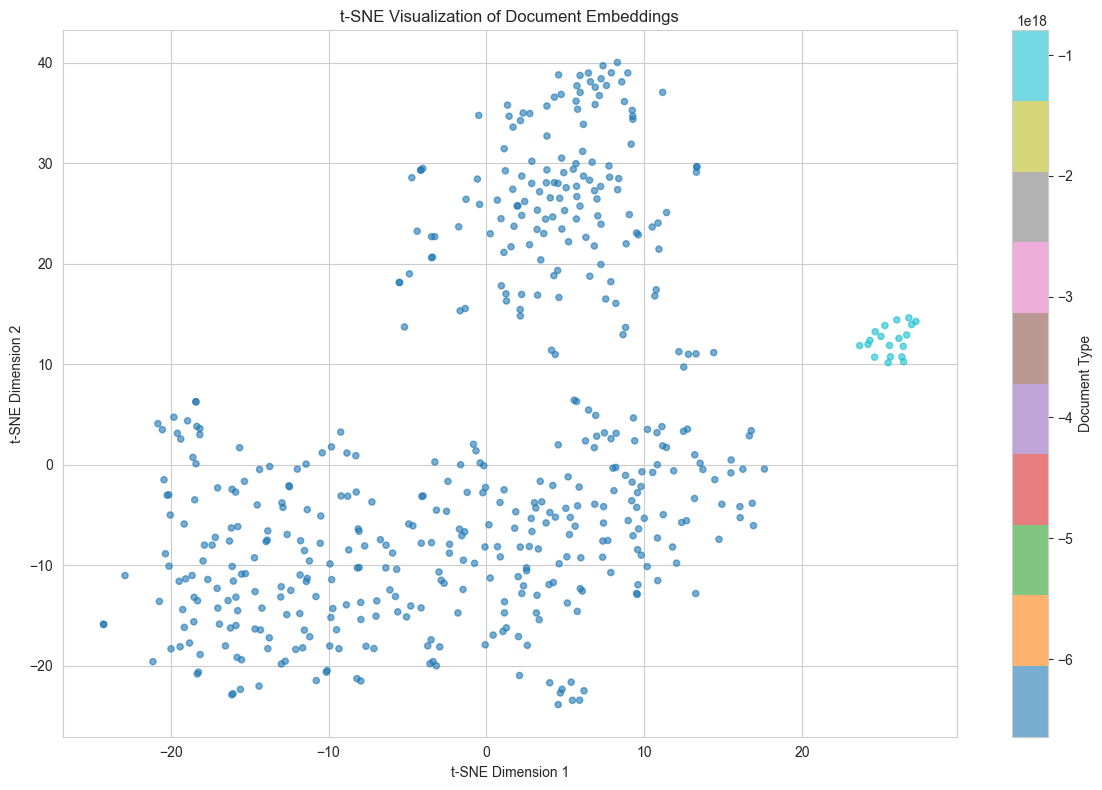

Documents with similar content should cluster together


In [7]:
# t-SNE visualization
# t-SNE mesuures high-dimensional data by giving each datapoint a location in a two or three-dimensional map.
print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(sample_embeddings)

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=[hash(t) for t in sample_types], 
                     alpha=0.6, s=20, cmap='tab10')
plt.title('t-SNE Visualization of Document Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(scatter, label='Document Type')
plt.tight_layout()
plt.show()

print("Documents with similar content should cluster together")

## 5. Hybrid vs Dense-Only Comparison

In [8]:
# Compare hybrid retrieval vs dense-only
comparison_results = []

for query in test_queries[:5]:  # Test on subset
    # Hybrid retrieval
    hybrid_docs, hybrid_metrics = retriever.retrieve(query, top_k=5, use_expansion=True)
    
    # Dense-only (simulated by using only dense results)
    dense_results = retriever._dense_retrieve([query])
    
    comparison_results.append({
        'query': query[:50],
        'hybrid_score': hybrid_metrics.get('avg_score', 0),
        'dense_score': np.mean([score for _, score in dense_results[:5]])
    })

comparison_df = pd.DataFrame(comparison_results)
comparison_df

,query,hybrid_score,dense_score
0,What are the early symptoms of Alzheimer's dis...,1.439346,0.980245
1,How is MMSE score interpreted?,0.176647,0.968571
2,What treatments are available for Alzheimer's?,1.516352,0.977880
3,What are the risk factors for developing demen...,2.030248,0.977950
4,How can caregivers support Alzheimer's patients?,0.843250,0.977741


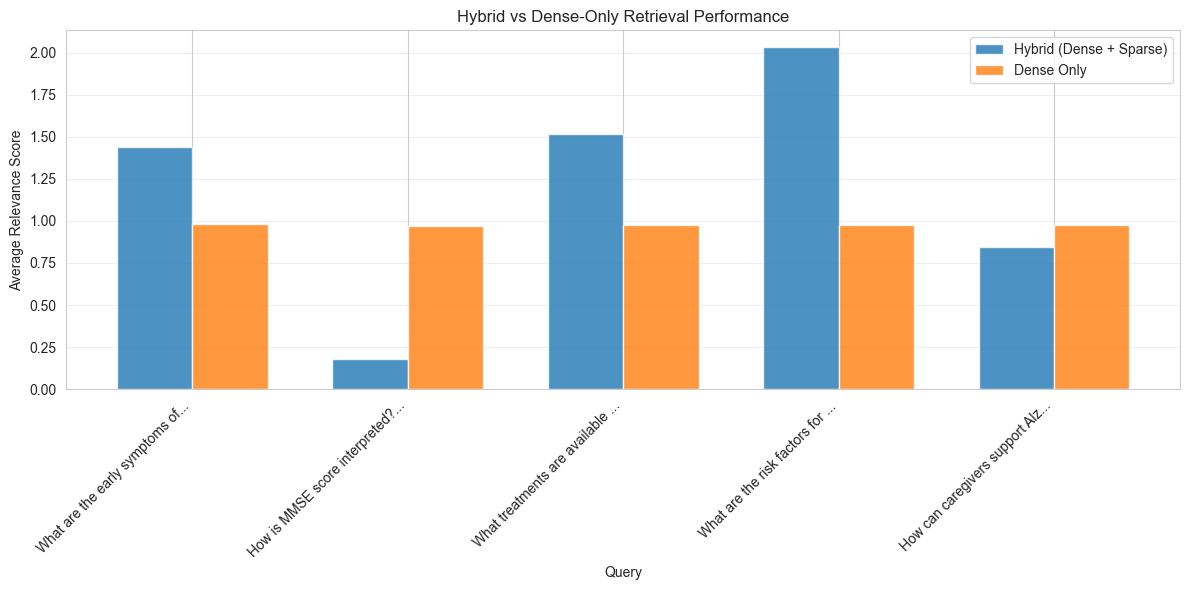


Hybrid avg: 1.201
Dense-only avg: 0.976
Improvement: 23.0%


In [9]:
# Visualize comparison
x = np.arange(len(comparison_df))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, comparison_df['hybrid_score'], width, label='Hybrid (Dense + Sparse)', alpha=0.8)
ax.bar(x + width/2, comparison_df['dense_score'], width, label='Dense Only', alpha=0.8)

ax.set_xlabel('Query')
ax.set_ylabel('Average Relevance Score')
ax.set_title('Hybrid vs Dense-Only Retrieval Performance')
ax.set_xticks(x)
ax.set_xticklabels([q[:30] + '...' for q in comparison_df['query']], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nHybrid avg: {comparison_df['hybrid_score'].mean():.3f}")
print(f"Dense-only avg: {comparison_df['dense_score'].mean():.3f}")
print(f"Improvement: {((comparison_df['hybrid_score'].mean() / comparison_df['dense_score'].mean()) - 1) * 100:.1f}%")

## 6. Failure Case Analysis

In [10]:
# Identify queries with low retrieval scores
low_score_threshold = 0.6
low_score_queries = results_df[results_df['avg_score'] < low_score_threshold]

print(f"Queries with avg score < {low_score_threshold}:")
print(low_score_queries[['query', 'avg_score']])

if len(low_score_queries) > 0:
    print("\n⚠️  These queries may need:")
    print("  - More relevant documents in the knowledge base")
    print("  - Better query expansion")
    print("  - Improved embedding model")
else:
    print("\n✅ All queries have good retrieval scores!")

Queries with avg score < 0.6:
                                               query  avg_score
1                     How is MMSE score interpreted?   0.176647
6                    How does MoCA differ from MMSE?   0.000000
7  What lifestyle changes can reduce Alzheimer's ...   0.055269

⚠️  These queries may need:
  - More relevant documents in the knowledge base
  - Better query expansion
  - Improved embedding model


## 7. Recommendations

Based on the analysis:

1. **Retrieval Quality**: Target avg score > 0.70 for reliable results
2. **Hybrid Approach**: Combining dense + sparse improves coverage
3. **Embedding Clusters**: Well-separated clusters indicate good semantic understanding
4. **Failure Cases**: Address low-scoring queries by adding relevant documents or improving query expansion